#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from docx import Document
from docx.shared import Inches
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from scipy.stats import f_oneway, kendalltau, spearmanr
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from pygam import LogisticGAM, s
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import RMSprop

/Users/violetapascuallaborda/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/violetapascuallaborda/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
2024-07-03 22:40:12.033110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Importing data

In [2]:
df_cluster = pd.read_excel('/Users/violetapascuallaborda/Desktop/Analysis/Clusters.xlsx')
df_scales =  pd.read_excel('/Users/violetapascuallaborda/Desktop/Analysis/Wellbeing_Scales.xlsx')

df_merged = pd.merge(df_cluster, df_scales, on='Participant_ID')
df = df_merged.drop(['Participant_ID', 'ZKPQ_INFREQ'], axis=1)

In [3]:
df

,Mean_Predictability_Negative,Cluster,PA,NA.,ERQ_CR,ERQ_ES,UPPSP_NU,UPPSP_PU,UPPSP_SS,UPPSP_PMD,...,ZKPQ_N_ANX,ZKPQ_ACT,ZKPQ_SY,ZKPQ_IMPSS,ZKPQ_AGG_HOST,SPQ,SPQ_IR,MSSB_POS,MSSB_NEG,MSSB_DES
0,0.366667,0,43,23,6.170000,5.75,9,11,12,5.0,...,12.0,10.0,10.0,11.0,1.0,2.516,3.0205,1.747,2.229,1.9
1,0.033333,1,32,14,4.830000,2.25,6,9,8,7.0,...,1.0,9.0,13.0,7.0,7.0,1.000,1.0000,0.000,1.000,0.0
2,0.166667,0,27,32,4.000000,3.25,13,11,8,7.0,...,17.0,1.0,10.0,5.0,11.0,1.000,3.0000,2.000,0.000,0.0
3,-0.400000,1,34,13,5.333333,3.25,6,10,11,7.0,...,2.0,8.0,0.0,8.0,5.0,0.000,1.0000,1.000,6.000,4.0
4,-0.500000,1,32,18,4.500000,4.50,5,7,12,9.0,...,8.0,12.0,10.0,7.0,3.0,3.000,1.0000,0.000,2.000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,-0.100000,1,28,21,5.330000,4.50,10,13,13,9.0,...,4.0,12.0,6.0,11.0,8.0,2.000,1.0000,0.000,3.000,4.0
144,-0.300000,2,34,16,4.500000,1.75,13,9,10,6.0,...,10.0,8.0,6.0,11.0,8.0,0.000,1.0000,3.000,1.000,4.0
145,-0.033333,1,37,20,5.830000,1.75,5,9,14,8.0,...,8.0,11.0,8.0,10.0,4.0,6.000,5.0000,2.000,0.000,1.0
146,0.200000,0,34,27,5.000000,1.75,10,8,5,10.0,...,15.0,5.0,11.0,2.0,10.0,1.000,1.0000,0.000,0.000,2.0


### **Metrics of Scales for each cluster ordered by 'Mean_Predictability_Negative'**

In [4]:
# Define metrics by group
PANAS = ["PA", "NA."]
ERQ = ["ERQ_CR", "ERQ_ES"]
UPPSP = ["UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV"]
BIS_BAS = ["BIS", "BAS_D", "BAS_RR", "BAS_FS"]
TEPS = ["TEPS_AF", "TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum", "RRQ_Ref"]
ASI3 = ["ASI_P", "ASI_C", "ASI_S"]
ZKPQ = ["ZKPQ_N_ANX", "ZKPQ_ACT", "ZKPQ_SY", "ZKPQ_IMPSS", "ZKPQ_AGG_HOST"]  
SPQ = ["SPQ", "SPQ_IR"]
MSSB = ["MSSB_POS", "MSSB_NEG", "MSSB_DES"]

# Complete list of metrics
all_metrics = PANAS + ERQ + UPPSP + BIS_BAS + TEPS + SHS + FS + LOTR + RRQ + ASI3 + ZKPQ + SPQ + MSSB

# Calculate metrics for each cluster
agg_funcs = {metric: ['mean', 'std'] for metric in all_metrics}
metrics = df.groupby('Cluster').agg(agg_funcs)
metrics.columns = ['_'.join(col) for col in metrics.columns]
metrics = metrics.reset_index()

# Add cluster size
metrics['Cluster_Size'] = df['Cluster'].value_counts().sort_index().values

# Calculate SE for each metric
for metric in all_metrics:
    metrics[f'{metric}_SE'] = metrics[f'{metric}_std'] / np.sqrt(metrics['Cluster_Size'])

# Limit values to two decimal places
metrics = metrics.round(2)

# Order clusters by 'Mean_Predictability_Negative_mean'
ordered_clusters = df.groupby('Cluster')['Mean_Predictability_Negative'].mean().sort_values().index
df['Cluster'] = pd.Categorical(df['Cluster'], categories=ordered_clusters, ordered=True)

# Create a Word document
doc = Document()

# Function to add metrics to the document
def add_metrics_to_doc(group_name, variables, doc):
    doc.add_heading(group_name, level=1)
    
    for variable in variables:
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.boxplot(ax=ax, x='Cluster', y=variable, data=df, order=ordered_clusters)
        
        # Save the figure in a buffer
        import io
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png', bbox_inches='tight')
        buffer.seek(0)
        
        # Add the image to the document
        doc.add_picture(buffer, width=Inches(6))
        plt.close(fig)
        buffer.close()
        
        # Add table of metrics
        table_data = metrics[['Cluster', 'Cluster_Size', f'{variable}_mean', f'{variable}_std', f'{variable}_SE']]
        table = doc.add_table(rows=1, cols=len(table_data.columns))
        
        # Add borders to the table
        tbl = table._tbl  # Get the actual table xml element
        for cell in tbl.iter_tcs():
            tcPr = cell.tcPr  # Get the table cell properties element
            tcBorders = OxmlElement('w:tcBorders')  # Create a new borders element

            for border_name in ['top', 'start', 'bottom', 'end']:
                border = OxmlElement(f'w:{border_name}')
                border.set(qn('w:val'), 'single')
                border.set(qn('w:sz'), '4')  # 4 twips is 0.5 pt
                border.set(qn('w:space'), '0')
                border.set(qn('w:color'), '000000')  # Black color
                tcBorders.append(border)

            tcPr.append(tcBorders)  # Append the borders element to the cell properties

        hdr_cells = table.rows[0].cells
        for i, col_name in enumerate(table_data.columns):
            hdr_cells[i].text = col_name
        
        for row in table_data.itertuples(index=False):
            row_cells = table.add_row().cells
            for i, value in enumerate(row):
                row_cells[i].text = str(value)
                
                # Add borders to each data cell
                tcPr = row_cells[i]._element.get_or_add_tcPr()
                tcBorders = OxmlElement('w:tcBorders')
                for border_name in ['top', 'start', 'bottom', 'end']:
                    border = OxmlElement(f'w:{border_name}')
                    border.set(qn('w:val'), 'single')
                    border.set(qn('w:sz'), '4')
                    border.set(qn('w:space'), '0')
                    border.set(qn('w:color'), '000000')
                    tcBorders.append(border)
                tcPr.append(tcBorders)

        doc.add_paragraph()

# Add metrics to the document
add_metrics_to_doc('Metrics Analysis', all_metrics, doc)

# Save the document
doc.save('/Users/violetapascuallaborda/Desktop/Analysis/Scales_Boxplots_Ordered_Mean_Pred_Negative.docx')

### **ANOVA**

In [6]:
# Calculate p-value using ANOVA for each metric
anova_results = []

for metric in all_metrics:
    groups = [df[df['Cluster'] == cluster][metric] for cluster in ordered_clusters]
    f_stat, p_value = f_oneway(*groups)
    anova_results.append({'Metric': metric, 'ANOVA_p_value': p_value})

# Create a DataFrame with the results
anova_df = pd.DataFrame(anova_results)
anova_df

,Metric,ANOVA_p_value
0,PA,0.147870
1,NA.,0.769424
2,ERQ_CR,0.719266
3,ERQ_ES,0.758609
4,UPPSP_NU,0.427851
5,UPPSP_PU,0.828389
6,UPPSP_SS,0.195096
7,UPPSP_PMD,0.056696
8,UPPSP_PSV,0.138940
9,BIS,0.063027


In [7]:
# Take the 3 varibales with higher significant difference
top_3_anova_df = anova_df.sort_values(by='ANOVA_p_value').head(3)
top_3_anova_df

,Metric,ANOVA_p_value
7,UPPSP_PMD,0.056696
9,BIS,0.063027
25,ZKPQ_SY,0.063241


### **Ordinal Analysis**

#### Correlations. Kendall's Tau & Spearman's Rho

/var/folders/3s/4d1my8ts76j3xs22jwl80rym0000gn/T/ipykernel_85949/3051793004.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kendall_df['Kendall_tau'], y=kendall_df.index, palette=['blue' if p < 0.05 else '#b0b0b0' for p in kendall_df['p_value']])


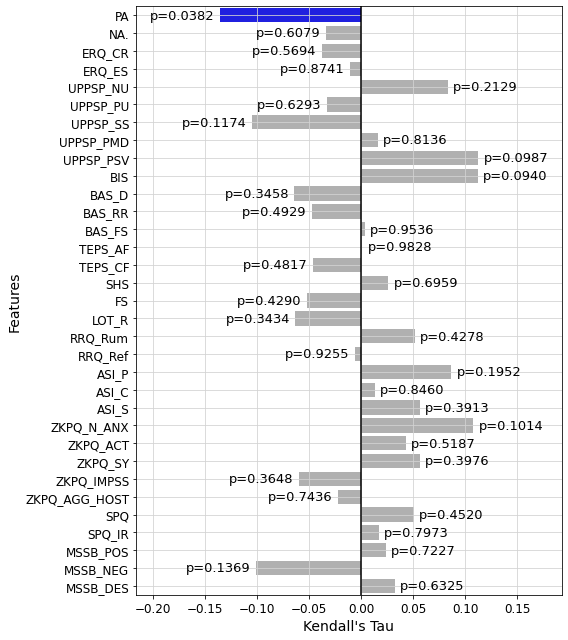

In [8]:
# Calculate Kendall's Tau correlation
kendall_results = {var: kendalltau(df['Cluster'], df[var]) for var in all_metrics}

# Create a DataFrame for Kendall's Tau results
kendall_df = pd.DataFrame(kendall_results, index=['Kendall_tau', 'p_value']).T

# Create the vertical bar plot
plt.figure(figsize=(8, 9))
sns.barplot(x=kendall_df['Kendall_tau'], y=kendall_df.index, palette=['blue' if p < 0.05 else '#b0b0b0' for p in kendall_df['p_value']])
plt.grid(True, color='#d3d3d3')
plt.axvline(0, color='black', linestyle='-')
plt.xlabel("Kendall's Tau", fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate the plot with p-values
for i, (tau, pval) in enumerate(zip(kendall_df['Kendall_tau'], kendall_df['p_value'])):
    ha = 'left' if tau > 0 else 'right'
    offset = 0.005 if tau > 0 else -0.005
    plt.text(offset + tau, i, f'p={pval:.4f}', ha=ha, va='center', fontsize=13, color='black')

plt.xlim(min(kendall_df['Kendall_tau']) - 0.08, max(kendall_df['Kendall_tau']) + 0.08)
plt.tight_layout()
plt.show()

/var/folders/3s/4d1my8ts76j3xs22jwl80rym0000gn/T/ipykernel_85949/2474401195.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spearman_df['Spearman_rho'], y=spearman_df.index, palette=['blue' if p < 0.05 else '#b0b0b0' for p in spearman_df['p_value']])


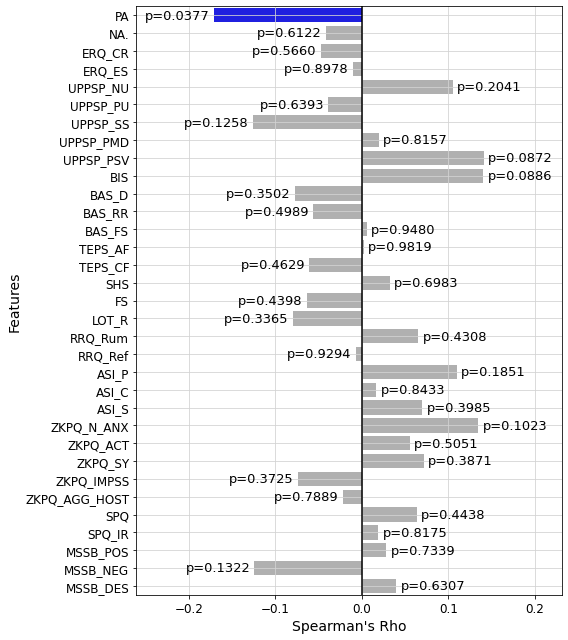

In [9]:
# Calculate Spearman's rank correlation
spearman_results = {var: spearmanr(df['Cluster'], df[var]) for var in all_metrics}

# Create a DataFrame for Spearman's results
spearman_df = pd.DataFrame(spearman_results, index=['Spearman_rho', 'p_value']).T

# Create the vertical bar plot
plt.figure(figsize=(8, 9))  # Maintain the original size of the plot
sns.barplot(x=spearman_df['Spearman_rho'], y=spearman_df.index, palette=['blue' if p < 0.05 else '#b0b0b0' for p in spearman_df['p_value']])
plt.grid(True, color='#d3d3d3')
plt.axvline(0, color='black', linestyle='-')
plt.xlabel("Spearman's Rho", fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate the plot with p-values
for i, (rho, pval) in enumerate(zip(spearman_df['Spearman_rho'], spearman_df['p_value'])):
    ha = 'left' if rho > 0 else 'right'
    offset = 0.005 if rho > 0 else -0.005
    plt.text(rho + offset, i, f'p={pval:.4f}', ha=ha, va='center', fontsize=13, color='black')

plt.xlim(min(spearman_df['Spearman_rho']) - 0.09, max(spearman_df['Spearman_rho']) + 0.09)
plt.tight_layout()
plt.show()

#### Ordinal Logistic Regression

Optimization terminated successfully.
         Current function value: 0.928338
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38


/var/folders/3s/4d1my8ts76j3xs22jwl80rym0000gn/T/ipykernel_85949/2744065485.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df['Coefficient'], y=results_df.index, palette=['blue' if p < 0.05 else '#b0b0b0' for p in results_df['p-value']])


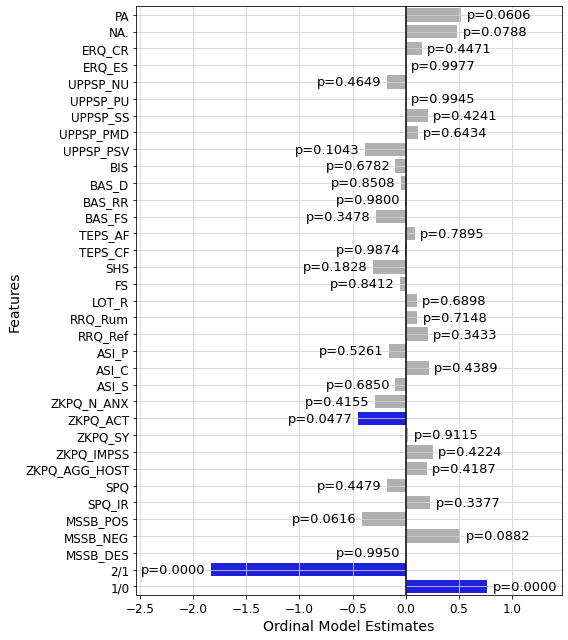

In [10]:
# Step 1: Scale the data
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(df[all_metrics])
scaled_df = pd.DataFrame(scaled_metrics, columns=all_metrics)

# Fit the ordinal logistic regression model
mod = OrderedModel(df['Cluster'], scaled_df, distr='logit')
res = mod.fit(method='bfgs')

# Extract coefficients and p-values
coefficients = res.params
p_values = res.pvalues

# Combine coefficients and p-values into a DataFrame for plotting
results_df = pd.DataFrame({'Coefficient': coefficients, 'p-value': p_values})

# Create the vertical bar plot
plt.figure(figsize=(8, 9))
sns.barplot(x=results_df['Coefficient'], y=results_df.index, palette=['blue' if p < 0.05 else '#b0b0b0' for p in results_df['p-value']])
plt.grid(True, color='#d3d3d3')
plt.axvline(0, color='black', linestyle='-')
plt.xlabel('Ordinal Model Estimates', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate the plot with p-values
for i, (coef, pval) in enumerate(zip(results_df['Coefficient'], results_df['p-value'])):
    ha = 'left' if coef > 0 else 'right'
    offset = 0.05 if coef > 0 else -0.05
    plt.text(coef + offset, i, f'p={pval:.4f}', ha=ha, va='center', fontsize=13)

plt.xlim(min(results_df['Coefficient']) - 0.7, max(results_df['Coefficient']) + 0.7)
plt.tight_layout()
plt.show()

#### Second degree Polinomial fit

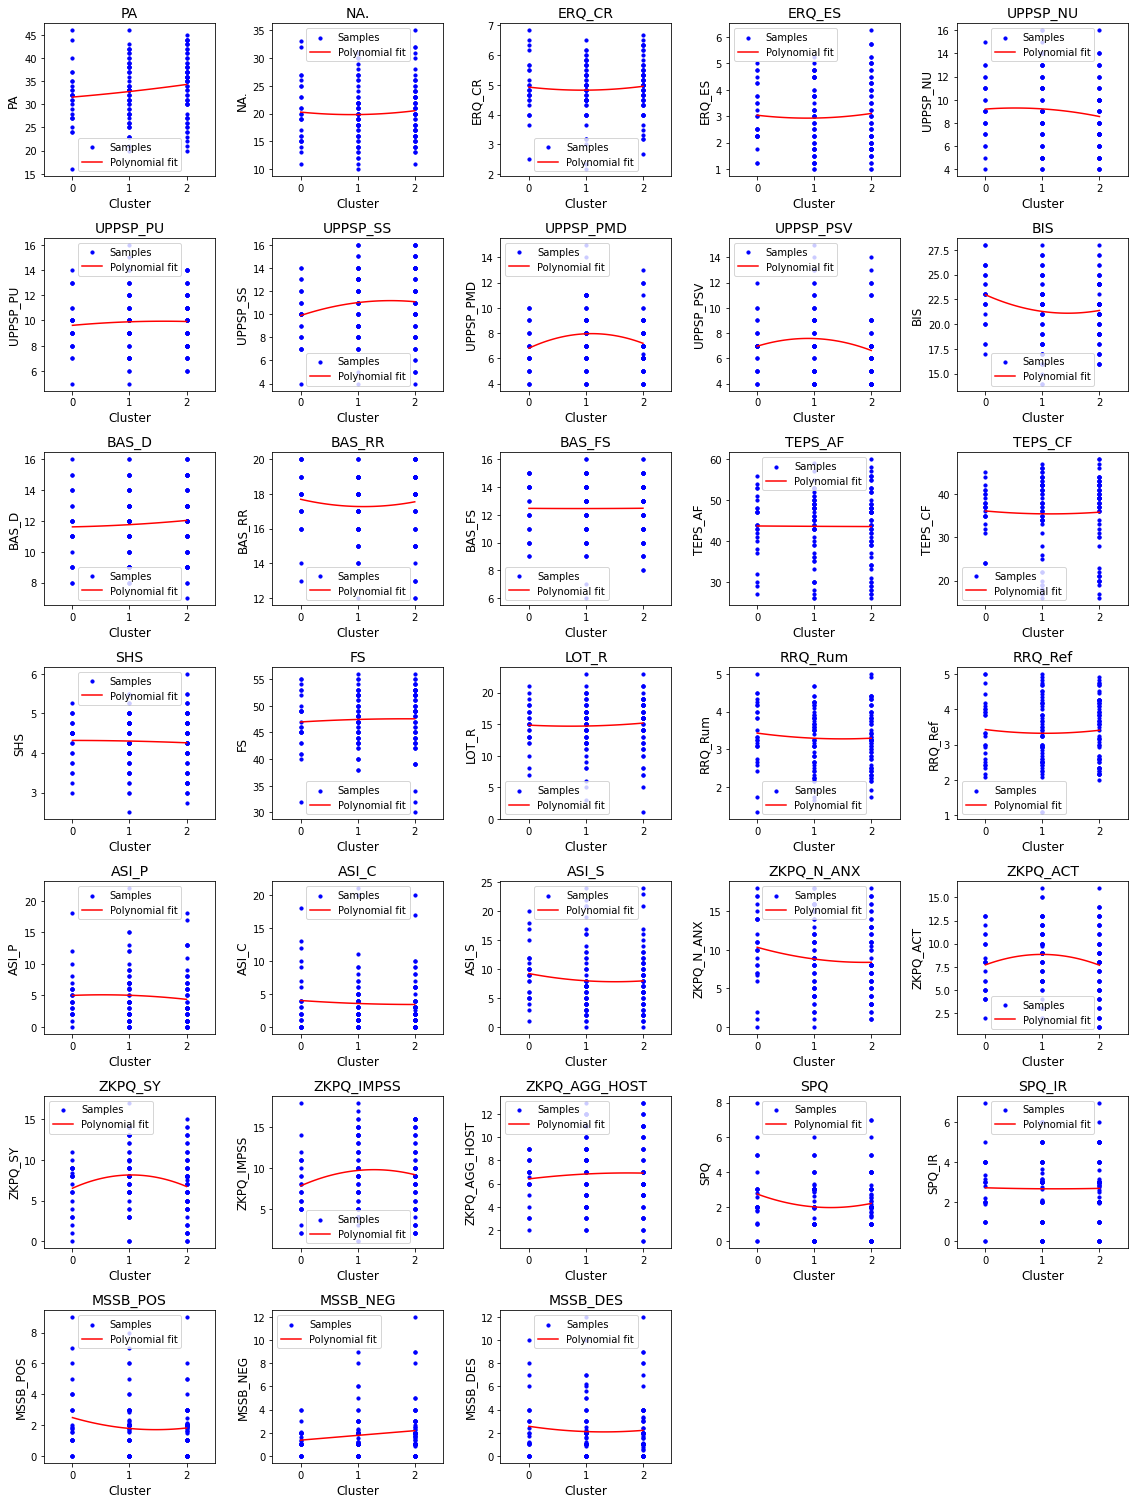

In [11]:
# Create subplots
num_vars = len(all_metrics)
num_cols = 5
num_rows = int(np.ceil(num_vars / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3 * num_rows))
axes = axes.flatten()

# DataFrame to store coefficients and p-values
results_list = []

# Fit and plot second-degree polynomials for each variable
for i, var in enumerate(all_metrics):
    x = df['Cluster'].cat.codes.values.reshape(-1, 1)
    y = df[var].values

    # Create second-degree polynomial features
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)

    # Fit the polynomial linear regression model
    model = sm.OLS(y, x_poly).fit()

    # Predict fitted values
    x_fit = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_fit = model.predict(poly.transform(x_fit))

    # Plot original data and polynomial fit
    axes[i].scatter(x, y, color='blue', label='Samples', s=10)  # Adjust point size
    axes[i].plot(x_fit, y_fit, color='red', label='Polynomial fit', linewidth=1.5)
    axes[i].set_title(var, fontsize=14)
    axes[i].set_xlabel('Cluster', fontsize=12)
    axes[i].set_ylabel(var, fontsize=12)
    axes[i].legend(fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].set_xticks([0, 1, 2])
    axes[i].set_xlim(-0.5, 2.5)

    # Save coefficients and p-values to the list
    results_list.append({
        'Variable': var,
        'Coef_Intercept': model.params[0],
        'Coef_Linear': model.params[1],
        'Coef_Quadratic': model.params[2],
        'P_Intercept': model.pvalues[0],
        'P_Linear': model.pvalues[1],
        'P_Quadratic': model.pvalues[2]
    })

# Convert the list to a DataFrame
results_df = pd.DataFrame(results_list)

# Filter variables with p-values less than 0.05 for all three coefficients
significant_results = results_df[(results_df['P_Intercept'] < 0.05) & 
                                 (results_df['P_Linear'] < 0.05) & 
                                 (results_df['P_Quadratic'] < 0.05)]

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
significant_results

,Variable,Coef_Intercept,Coef_Linear,Coef_Quadratic,P_Intercept,P_Linear,P_Quadratic
7,UPPSP_PMD,6.807692,2.088525,-0.947941,1.158453e-32,0.020589,0.016810
25,ZKPQ_SY,6.512750,3.138965,-1.515965,1.383839e-15,0.035406,0.020938


### **Machine learning. Random Forest**

In [13]:
df.drop(['Mean_Predictability_Negative'], axis=1, inplace=True)
df

,Cluster,PA,NA.,ERQ_CR,ERQ_ES,UPPSP_NU,UPPSP_PU,UPPSP_SS,UPPSP_PMD,UPPSP_PSV,...,ZKPQ_N_ANX,ZKPQ_ACT,ZKPQ_SY,ZKPQ_IMPSS,ZKPQ_AGG_HOST,SPQ,SPQ_IR,MSSB_POS,MSSB_NEG,MSSB_DES
0,0,43,23,6.170000,5.75,9,11,12,5.0,4,...,12.0,10.0,10.0,11.0,1.0,2.516,3.0205,1.747,2.229,1.9
1,1,32,14,4.830000,2.25,6,9,8,7.0,5,...,1.0,9.0,13.0,7.0,7.0,1.000,1.0000,0.000,1.000,0.0
2,0,27,32,4.000000,3.25,13,11,8,7.0,8,...,17.0,1.0,10.0,5.0,11.0,1.000,3.0000,2.000,0.000,0.0
3,1,34,13,5.333333,3.25,6,10,11,7.0,12,...,2.0,8.0,0.0,8.0,5.0,0.000,1.0000,1.000,6.000,4.0
4,1,32,18,4.500000,4.50,5,7,12,9.0,7,...,8.0,12.0,10.0,7.0,3.0,3.000,1.0000,0.000,2.000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1,28,21,5.330000,4.50,10,13,13,9.0,5,...,4.0,12.0,6.0,11.0,8.0,2.000,1.0000,0.000,3.000,4.0
144,2,34,16,4.500000,1.75,13,9,10,6.0,5,...,10.0,8.0,6.0,11.0,8.0,0.000,1.0000,3.000,1.000,4.0
145,1,37,20,5.830000,1.75,5,9,14,8.0,10,...,8.0,11.0,8.0,10.0,4.0,6.000,5.0000,2.000,0.000,1.0
146,0,34,27,5.000000,1.75,10,8,5,10.0,6,...,15.0,5.0,11.0,2.0,10.0,1.000,1.0000,0.000,0.000,2.0


In [14]:
X = df.drop(columns=['Cluster'])
y = df['Cluster']

# Separo en training data y validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Check if the classes are balanced

In [15]:
df['Cluster'].value_counts()

Cluster
0    64
1    58
2    26
Name: count, dtype: int64

#### RF without data balance

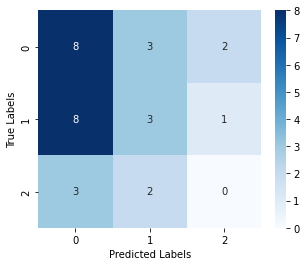

ROC-AUC Score: 0.4150401094910899
F-1 Score: 0.33666666666666667


In [16]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions and obtain probabilities
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

# Confusion matrix
classes = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC-AUC (para multiclase one-vs-rest)
y_probs = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# F-1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Para el promedio ponderado de clases
print("F-1 Score:", f1)

#### RF with SMOTE

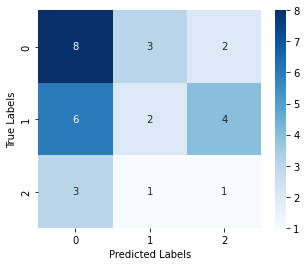

ROC-AUC Score: 0.48992179207865477
F-1 Score: 0.3477777777777778


In [17]:
# Find the minority class and its size
counter = Counter(y_train)
minority_class = min(counter, key=counter.get)
minority_class_size = counter[minority_class]

# Adjust the value of k_neighbors for SMOTE
k_neighbors = min(5, minority_class_size - 1)

# Apply SMOTE with the adjusted number of k_neighbors
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Fit the Random Forest model with class weights
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_resampled, y_resampled)

# Make predictions and obtain probabilities
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

# Confusion matrix
classes = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC-AUC (para multiclase one-vs-rest)
y_probs = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# F-1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Para el promedio ponderado de clases
print("F-1 Score:", f1)

#### RF with CLASS Weight

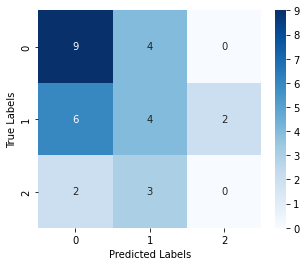

ROC-AUC Score: 0.46445226523657895
F-1 Score: 0.3991304347826087


In [18]:
# Fit the Random Forest model with specified class weights
class_weights = {
    0: 148/64,
    1: 148/58,
    2: 148/26
}
clf = RandomForestClassifier(class_weight=class_weights)
clf.fit(X_train, y_train)

# Make predictions and obtain probabilities
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

# Confusion matrix
classes = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC-AUC (para multiclase one-vs-rest)
y_probs = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# F-1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Para el promedio ponderado de clases
print("F-1 Score:", f1)

#### RF with GAM

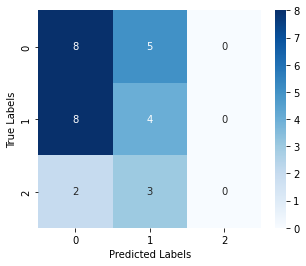

ROC-AUC Score: 0.46445226523657895
F-1 Score: 0.35698924731182796


In [19]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get the number of classes
num_classes = len(np.unique(y_train))

# Create and fit a GAM model for each class
gams = []
for i in range(num_classes):
    gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) +
                      s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) +
                      s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) +
                      s(30) + s(31) + s(32)).fit(X_train_scaled, y_train == i)
    gams.append(gam)

# Make predictions for each class and select the class with the highest probability
preds = np.zeros((X_test_scaled.shape[0], num_classes))
for i, gam in enumerate(gams):
    preds[:, i] = gam.predict_proba(X_test_scaled)

y_pred = np.argmax(preds, axis=1)

# Confusion matrix
classes = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC-AUC (para multiclase one-vs-rest)
y_probs = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# F-1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Para el promedio ponderado de clases
print("F-1 Score:", f1)

#### RF with VAE

Epoch 1/50
4/4 [==============================] - 1s 86ms/step - loss: 42.1005 - val_loss: 41.8958
Epoch 2/50
4/4 [==============================] - 0s 11ms/step - loss: 41.4461 - val_loss: 41.7365
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 41.4700 - val_loss: 41.4040
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 40.9180 - val_loss: 40.7962
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 40.9649 - val_loss: 40.7698
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 39.8576 - val_loss: 40.3427
Epoch 7/50
4/4 [==============================] - 0s 12ms/step - loss: 39.9232 - val_loss: 39.9266
Epoch 8/50
4/4 [==============================] - 0s 13ms/step - loss: 39.1299 - val_loss: 39.8232
Epoch 9/50
4/4 [==============================] - 0s 10ms/step - loss: 38.9098 - val_loss: 39.3432
Epoch 10/50
4/4 [==============================] - 0s 11ms/step - loss: 38.5256 - val_loss: 38.4808
Epoch 11/

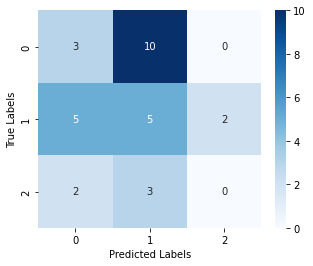

ROC-AUC Score: 0.4088986090162561
F-1 Score: 0.2463768115942029


In [20]:
# Define the architecture of the VAE
original_dim = X_train.shape[1]
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Create the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z])

# Create the decoder model
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(inputs, x_decoded_mean)

# Define the VAE loss
reconstruction_loss = mse(inputs, x_decoded_mean)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=RMSprop())
vae.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, X_test_scaled))

# Use the encoder to obtain the latent representations
X_train_encoded = encoder.predict(X_train_scaled)[2]
X_test_encoded = encoder.predict(X_test_scaled)[2]

# Train a Random Forest classifier using the latent representations
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_encoded, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test_encoded)

# Confusion matrix
classes = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC-AUC (for multiclass one-vs-rest)
y_probs = clf.predict_proba(X_test_encoded)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# F-1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Para el promedio ponderado de clases
print("F-1 Score:", f1)